In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import math
np.log1p(math.e - 1)

1.0

In [2]:
hic = np.load("./hic_050.npy")

In [4]:
hic.shape

(50, 50)

In [5]:
print(hic)

[[2845.  748.  345. ...   26.   20.   18.]
 [ 748. 2845.  748. ...   19.   21.   17.]
 [ 345.  748. 2845. ...   42.   21.   18.]
 ...
 [  26.   19.   42. ... 1753.  355.  194.]
 [  20.   21.   21. ...  355. 1828.  489.]
 [  18.   17.   18. ...  194.  489. 1676.]]


In [6]:
hic.sum(axis=1)

array([5882., 6610., 7919., 5431., 6953., 6040., 8257., 9245., 8164.,
       9943., 9951., 6943., 4558., 5087., 9060., 5495., 6281., 4736.,
       7527., 7323., 4868., 6007., 5640., 5630., 4452., 5235., 5832.,
       8136., 3815., 5675., 4754., 6202., 5614., 7025., 3118., 4655.,
       7442., 4687., 6951., 6185., 5034., 6498., 6524., 5182., 5830.,
       5328., 5168., 4871., 4430., 3782.])

In [7]:
hic.sum(axis=0)

array([5882., 6610., 7919., 5431., 6953., 6040., 8257., 9245., 8164.,
       9943., 9951., 6943., 4558., 5087., 9060., 5495., 6281., 4736.,
       7527., 7323., 4868., 6007., 5640., 5630., 4452., 5235., 5832.,
       8136., 3815., 5675., 4754., 6202., 5614., 7025., 3118., 4655.,
       7442., 4687., 6951., 6185., 5034., 6498., 6524., 5182., 5830.,
       5328., 5168., 4871., 4430., 3782.])

<Axes: >

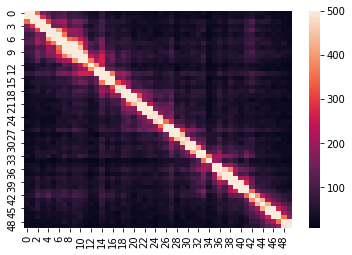

In [8]:
sns.heatmap(hic, vmax=500)

<Axes: >

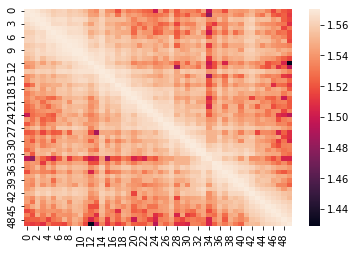

In [9]:
sns.heatmap(np.arctan(hic))

In [12]:
dfV = pd.read_csv("./data/WB_mesh/d10_V.csv")

In [ ]:
dfV.shape

In [ ]:
dfV.head()

In [ ]:
dfV.id.unique().shape

In [11]:
dfE = pd.read_csv("./data/WB_mesh/d10_E.csv")

In [ ]:
dfE.shape

In [ ]:
dfE.head()

In [ ]:
dfE.id1.unique().shape

In [ ]:
dfE.euc_dist.unique().shape

In [3]:
# initializing graph G
import networkx as nx

G = nx.Graph()

# getting vertices
dfV = pd.read_csv("./data/WB_mesh/d10_V.csv")

# adding vertices with coordinates
for n, x, y, z in zip(dfV.id, dfV.x, dfV.y, dfV.z):
    G.add_node(n, x = x, y = y, z = z)

# getting edges
dfE = pd.read_csv("./data/WB_mesh/d10_E.csv")
    
# adding edges with distance and weight
for n1, n2, d, w in zip(dfE.id1, dfE.id2, dfE.dist, dfE.weight):
    G.add_edge(n1, n2, dist = d, weight = w)


In [4]:
import random

def proponuj_g(structure, G):
    """
    structure = [(x0,y0,z0), ...]
    structure = [id0, id1, ...]
    G - graf csv, (networkx)
    """
    
    id0 = None
    
    # empty structure
    if structure == None or structure == []:
        structure = []
        # choosing start point index (randomly?)
        id0 = random.randint(0, len(G.nodes) - 1)
        structure.append(id0)
        return structure
    
    # usuwanie dublujących się krawedzi i testy (może wystarczy)
    # dodatkowo rozbudowywanie struktury (ścieżki) w środku, po wspólnych sąsiadach
    ## PREZENTACJA
    
    def add_to_end():
        # getting an index of one end of the structure
        i = random.choice([0, len(structure) - 1])
        end = True
        if i == 0:
            end = False
        id0 = structure[i]
        # get indexes of connected vertices
        neighbours = list(G[id0].keys())
        # finding new edges
        neighbours = list(set(neighbours).difference(set(structure)))
        if (neighbours == []):
            # we allow to rollback, when we are stuck
            # neighbours = list(G[id0].keys())
            # print("No new node has been added.")
            # or we remove stop point
            #structure.remove(id0)
            structure.pop(i)
            # and try somewhere else
            return add_in_the_middle()
        # taking weights of edges
        weights = []
        for n in neighbours:
            weights.append(G[id0][n]['weight'])
            # it may be flattened
            # weights.append(np.log1p(G[id0][n]['weight']))
        # choosing the next node index
        id1 = int(random.choices(neighbours, weights=weights, k=1)[0])
        if end:
            structure.append(id1)
        else:
            structure.insert(0, id1)
        
    def add_in_the_middle():
        # finding randomly 2 vertices and inserting additional vertice between them
        i = random.randint(0, len(structure) - 2)
        id0 = structure[i]
        id1 = structure[i+1]
        # looking for common neighbours
        neighbours0 = list(G[id0].keys())
        neighbours1 = list(G[id1].keys())
        neighbours0 = set(neighbours0).difference(set(structure))
        neighbours1 = set(neighbours1).difference(set(structure))
        neighbours = list(neighbours0.intersection(neighbours1))
        if (neighbours == []):
            # we do not add anything
            #print("No node has been added.")
            return
        # taking weights of edges
        weights = []
        for n in neighbours:
            weights.append(G[id0][n]['weight'] * G[id1][n]['weight'])
            # it may be flattened
            # weights.append(np.log1p(G[id0][n]['weight']) * np.log1p(G[id1][n]['weight']))
        # choosing the next node index
        id12 = int(random.choices(neighbours, weights=weights, k=1)[0])
        structure.insert(i, id12)
        
    MIN_MIDDLE_ADD = 10
    if len(structure)  < MIN_MIDDLE_ADD:
        add_to_end()
        return structure
    
    if random.randint(0, 1) == 0:
        add_to_end()
    else:
        add_in_the_middle()
    
    return structure
    

def get_structure_coordinates(struktura, G):
    def _add(id0):
        node = G.nodes[id0]
        x = node['x']
        y = node['y']
        z = node['z']
        coordinates.append([x, y, z])
    
    coordinates = []
    for id0 in struktura:
        _add(id0)
        
    return coordinates

   

In [5]:
def create_structure(iterations):
    structure = []
    for i in range(iterations):
        structure = proponuj_g(structure, G)
    #print("Structure contains " + str(len(structure)) + " vertices." )
    return structure

In [15]:
#initializing structure
v_n = []
for i in range(100):
    s = create_structure(5000)
    v_n.append(len(s))
print(np.mean(v_n)) # 420
print(np.max(v_n)) # 700
print(np.min(v_n)) # 70

727.3
1271
45


In [16]:
# tworzenie struktury
struktura = []
for i in range(1000):
    struktura = proponuj_g(struktura, G)
#print(struktura)
print(len(struktura))
print(len(np.unique(struktura)))
print(len(np.unique(struktura)) / len(struktura))
#print(get_structure_coordinates(struktura, G))

335
335
1.0


In [17]:
struktura = []

In [18]:
struktura = proponuj_g(struktura, G)
print((struktura))
if (len(np.unique(struktura)) != len(struktura)):
    print("ERROR")

[1377]


Tera Czarek

In [6]:
import networkx as nx
import numpy as np
from scipy.spatial import distance_matrix
import math as m
from scipy.stats import pearsonr

In [7]:
hic = np.load("hic_020.npy")


def distance_map(structure):
    # returns distance map of given structure
    map_ = distance_matrix(structure, structure)
    return map_

In [8]:
def calc_midpoint(point1, point2):
    return [(point1[0] + point2[0])/2, (point1[1] + point2[1])/2, (point1[2] + point2[2])/2]

In [9]:
def split(a, n):
    k, m = divmod(len(a), n)
    return list((a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n)))

def add_n_points(struct, n):
    new_struct = []
    divided = split(struct, n+1)
    for i in range(n):
        new_struct.extend(divided[i])
        new_struct.append(calc_midpoint(divided[i][-1], divided[i+1][0]))
    new_struct.extend(divided[n])
    return new_struct

def add_points_to_structure(structure, dim):
    '''
    adds points to the structure so it hase same dimension as dim (hic matrix)
    '''
    n = len(structure)
    if n == 1:
        raise Exception("cannot add points to 1-point structure")
    nr_points = dim - n
    if nr_points == 0:
        return structure
    elif nr_points < 0:
        return structure[:dim] #todo lepiej
        # nie ucinać ostatnich
    while nr_points > 0:
        if nr_points >= n:
            structure = add_n_points(structure, n-1)
            nr_points -= n-1
            n = len(structure)
        else:
            structure = add_n_points(structure, nr_points)
            nr_points = 0
    return structure


In [10]:
    
def reverse_matr(matr):
    m = np.asarray(matr)
    return m/(m*m)    

In [11]:
    
def calc_corr(matr1, matr2):
    corr, _ = pearsonr(matr1.flatten(), matr2.flatten())
    return corr

In [12]:
def f_similarity(structure, hic):
    if len(structure) == 1:
        return 0
    dim = len(hic)
    structure = add_points_to_structure(structure, dim)
    dist_map = distance_map(structure)
    reversed_hic = reverse_matr(hic)
    return calc_corr(reversed_hic, dist_map)
    
structure = [[1, i+1, i*2] for i in range(20)]
f_similarity(structure, hic)

0.8770778941727371

In [29]:
structure = add_points_to_structure(structure, 50)
structure

[[1, 1, 0],
 [1.0, 1.5, 1.0],
 [1, 2, 2],
 [1.0, 2.5, 3.0],
 [1.0, 2.75, 3.5],
 [1, 3, 4],
 [1.0, 3.5, 5.0],
 [1, 4, 6],
 [1.0, 4.5, 7.0],
 [1.0, 4.75, 7.5],
 [1, 5, 8],
 [1.0, 5.5, 9.0],
 [1, 6, 10],
 [1.0, 6.5, 11.0],
 [1.0, 6.75, 11.5],
 [1, 7, 12],
 [1.0, 7.5, 13.0],
 [1, 8, 14],
 [1.0, 8.25, 14.5],
 [1.0, 8.5, 15.0],
 [1, 9, 16],
 [1.0, 9.5, 17.0],
 [1.0, 9.75, 17.5],
 [1, 10, 18],
 [1.0, 10.5, 19.0],
 [1, 11, 20],
 [1.0, 11.25, 20.5],
 [1.0, 11.5, 21.0],
 [1, 12, 22],
 [1.0, 12.5, 23.0],
 [1.0, 12.75, 23.5],
 [1, 13, 24],
 [1.0, 13.5, 25.0],
 [1, 14, 26],
 [1.0, 14.25, 26.5],
 [1.0, 14.5, 27.0],
 [1, 15, 28],
 [1.0, 15.5, 29.0],
 [1.0, 15.75, 29.5],
 [1, 16, 30],
 [1.0, 16.5, 31.0],
 [1, 17, 32],
 [1.0, 17.25, 32.5],
 [1.0, 17.5, 33.0],
 [1, 18, 34],
 [1.0, 18.5, 35.0],
 [1.0, 18.75, 35.5],
 [1, 19, 36],
 [1.0, 19.5, 37.0],
 [1, 20, 38]]

# simulated annealing
zmniejszanie temperatury, w celu znalezienia max globalnego
zależy od możliwości ruchu w g
na początek infalcja - rozszerzanie struktury

Zaczynamy od temperatury T0 i jakiejś struktury.
Nowa struktura z g na podstawie f i aktualnej temperatury.
Zazwyczaj min(exp(-fx-fy/T), 1), liczymy różnice w podobieństwie dla dwóch struktur x i y
wybieramy kolejne punkty na podstawie tego i rozbudowujemy jedną ścieżkę


# MCMC

próbkowanie Gibbsa - najprostsze, ale tego się nie używa w tym projekcie
losowanie xs w celu zamodelowania wielowymiarowej gęstości

algorytm Metropolisa-Hastingsa - to mamy zrobić (zalecenie prowadzącego)
losuje ścieżki, w całości
dostajemy zbiór wielu ścieżek
wybieramy najlepsze, albo coś z nich łączymy

losujemy nową strukturę, którą akceptujemy lub nie

wzorki są na slajdach (najprościej min(fy/fx, 1) dla symetrycznych gęstości - możemy to założyć)
albo liczymy prawdopodobieństwa wylosowania kolejnych struktur, można zwracać p-stwa w funkcji g utworzenia danej ścieżki, wystarczy wtedy wymnażać sobie wagi, może jakoś przeskalować, ale można też pominąć i się nie męczyć (prowadzący nie będzie się czepiał)

f liczymy z funkcji podobieństwa

w symulacjach, jak mamy wykresik, odcinamy początek, bo jest zawsze skorelowany
można odpalić mcmc kilka razy


po sym. wyrza... otrzymujemy jedną strukturę
po mcmc otrzymujemy całą próbkę, wiele struktur
z nich wybieramy pewnie najlepszą

ale można też zaszaleć

w wynikach mają być wykresy podobieństwa f względem ilości iteracji

ale można szaleć

krótka prezentacja 5 - 10 slajdów

In [21]:
# simulated annealing

def simulated_annealing(iterations, G, hic):
    import copy
    import math
    import random
    
    # initializing structure and start temperature
    structure = proponuj_g(None, G)
    T_0 = 1
    probabilities = []
    
    for i in range(1, iterations):
        # decreasing T
        T = T_0 * (1 - i/iterations)
        # proposing a new point to structure
        new_structure = copy.deepcopy(structure)
        new_structure = proponuj_g(new_structure, G)
        # if nothing has changed, nothing is done (notice, that it affects the length of probabilities)
        if new_structure == structure:
            continue
        # counting probability of selecting new_structure
        p = min(math.exp((-1) * (f_similarity(get_structure_coordinates(structure, G), hic) - f_similarity(get_structure_coordinates(new_structure, G), hic)) / T), 1)
        # saving probability for creating charts
        probabilities.append(p)
        # choosing structure
        if random.random() <= p:
            structure = new_structure
    return structure, probabilities
    

In [31]:
min(1, 2)

1

In [32]:
import math
math.exp(1)

2.718281828459045

In [33]:
import random
random.random()

0.7650995293506553

In [34]:
np.load("hic_020.npy")

array([[2845.,  748.,  345.,  162.,  122.,   83.,  101.,  114.,   71.,
          84.,   70.,   51.,   34.,   29.,   71.,   31.,   30.,   19.,
          35.,   25.],
       [ 748., 2845.,  748.,  283.,  160.,   91.,  113.,  115.,   83.,
          93.,   82.,   68.,   37.,   35.,   67.,   36.,   47.,   24.,
          46.,   32.],
       [ 345.,  748., 2845.,  741.,  302.,  170.,  200.,  210.,  116.,
         158.,  149.,  117.,   54.,   59.,   99.,   54.,   57.,   54.,
          59.,   41.],
       [ 162.,  283.,  741., 1497.,  511.,  155.,  154.,  172.,  103.,
         116.,  125.,   58.,   36.,   64.,   90.,   44.,   47.,   38.,
          34.,   36.],
       [ 122.,  160.,  302.,  511., 2080.,  711.,  412.,  279.,  191.,
         192.,  164.,   97.,   65.,   68.,   99.,   59.,   59.,   41.,
          61.,   44.],
       [  83.,   91.,  170.,  155.,  711., 1810.,  687.,  357.,  171.,
         181.,  170.,  100.,   43.,   59.,   78.,   40.,   54.,   45.,
          42.,   42.],
       [ 1

In [14]:
hic = np.load("hic_020.npy")

In [15]:
hic
G

In [24]:
simulated_annealing(10000, G, hic)

([701,
  826,
  832,
  828,
  827,
  833,
  991,
  990,
  1178,
  1169,
  1179,
  1160,
  989,
  1170,
  998,
  1353,
  1180,
  1364,
  1545,
  1365,
  1354,
  1181,
  1171,
  999,
  838,
  845,
  839,
  847,
  853,
  1017,
  846,
  1008,
  1016,
  1006,
  1007,
  844,
  1015,
  522,
  606,
  608,
  707,
  714,
  850,
  851,
  1024,
  1040,
  1033,
  874,
  865,
  882,
  734,
  873,
  621,
  726,
  733,
  725,
  864,
  720,
  857,
  719,
  520,
  521,
  605,
  607,
  706,
  712,
  713,
  842,
  1013,
  849,
  1023,
  1206,
  1414,
  1403,
  1402,
  1592,
  1591,
  1582,
  1581,
  1392,
  1216,
  1217,
  1579,
  1570,
  1390,
  1380,
  1391,
  1205,
  1012,
  848,
  1021,
  1022,
  1204,
  1032,
  1031,
  856,
  609,
  716,
  710,
  854,
  717,
  711,
  855,
  718,
  1039,
  1038,
  863,
  861,
  1037,
  870,
  862,
  731,
  724,
  871,
  732,
  881,
  872,
  1441,
  1596,
  1408,
  1410,
  1597,
  1409,
  1608,
  1419,
  1420,
  1430,
  1431,
  1254,
  1244,
  1255,
  1245,
  1256,
  7

In [23]:
# returned structure should be changed to get coordinates, so that it may be used in Chimera
structure, probabilities = simulated_annealing(1000, G, hic)
get_structure_coordinates(structure, G)

[[320.0, 427.239199200323, 522.5578117937447],
 [280.0, 427.239199200323, 522.5578117937447],
 [300.0, 415.6921938165305, 489.8979485566357],
 [280.0, 357.957166897568, 522.5578117937447],
 [300.0, 392.5981830489455, 522.5578117937447],
 [280.0, 381.051177665153, 489.8979485566357],
 [340.0, 346.41016151377545, 489.8979485566357],
 [320.0, 381.051177665153, 489.8979485566357],
 [300.0, 346.41016151377545, 489.8979485566357],
 [320.0, 369.50417228136047, 457.2380853195266],
 [300.0, 404.145188432738, 457.2380853195266],
 [260.0, 404.145188432738, 457.2380853195266],
 [300.0, 357.957166897568, 424.5782220824176],
 [280.0, 392.5981830489455, 424.5782220824176],
 [280.0, 369.50417228136047, 457.2380853195266],
 [260.0, 357.957166897568, 424.5782220824176],
 [240.0, 392.5981830489455, 424.5782220824176],
 [240.0, 369.50417228136047, 457.2380853195266],
 [220.0, 357.957166897568, 424.5782220824176],
 [240.0, 346.41016151377545, 391.9183588453085],
 [240.0, 323.31615074619043, 424.57822208241